In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.baselines.transformer import DecoderTransformer
from dynadojo.utils.lds import plot

In [7]:
import torch
import numpy as np

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

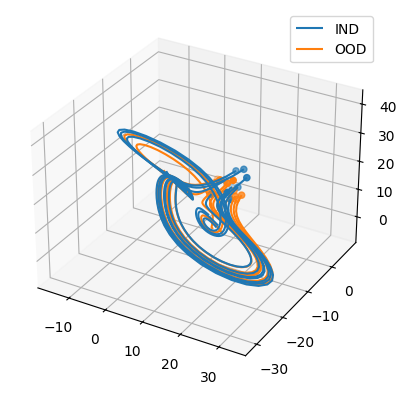

In [3]:
latent_dim = 3
embed_dim = latent_dim
n = 10
test_size = 10
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, 
                                    t_range=(0, 1),
                                    ))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
x0 = system.make_init_conds(n)
x = system.make_data(x0, timesteps=timesteps)
test0 = system.make_init_conds(30, in_dist=True)
test = system.make_data(test0, timesteps=timesteps, noisy=True)
plot([x, test], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [4]:
print("x shape", x.shape)
state = x[:, :-1, :].reshape(-1, x.shape[-1])
next_state = x[:, 1:, :].reshape(-1, x.shape[-1])

x shape (10, 100, 3)


In [5]:
# simple 3 layer neural network
model = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, latent_dim),
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [6]:
# training loop
x = torch.tensor(state, dtype=torch.float32).to(device)
y = torch.tensor(next_state, dtype=torch.float32).to(device)
for epoch in range(5000):
    optimizer.zero_grad()
    y_hat = model(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss.item()}")

Epoch 0: 191.3699188232422
Epoch 100: 5.446425437927246
Epoch 200: 1.5652008056640625
Epoch 300: 0.43079039454460144
Epoch 400: 0.15062519907951355
Epoch 500: 0.12011833488941193
Epoch 600: 0.1017388179898262
Epoch 700: 0.08902242034673691
Epoch 800: 0.07994294166564941
Epoch 900: 0.07267685234546661
Epoch 1000: 0.06691937148571014
Epoch 1100: 0.06173107773065567
Epoch 1200: 0.05697161331772804
Epoch 1300: 0.0526701919734478
Epoch 1400: 0.0488949753344059
Epoch 1500: 0.04546339064836502
Epoch 1600: 0.04243086278438568
Epoch 1700: 0.03987841680645943
Epoch 1800: 0.03770322725176811
Epoch 1900: 0.035752665251493454
Epoch 2000: 0.03390700742602348
Epoch 2100: 0.032227225601673126
Epoch 2200: 0.030726714059710503
Epoch 2300: 0.02932801842689514
Epoch 2400: 0.027980439364910126
Epoch 2500: 0.02662288211286068
Epoch 2600: 0.02556031569838524
Epoch 2700: 0.02465793490409851
Epoch 2800: 0.023606428876519203
Epoch 2900: 0.02344200760126114
Epoch 3000: 0.023784417659044266
Epoch 3100: 0.02248563

In [32]:
model.eval()
with torch.no_grad():
    next_input = torch.tensor(test0, dtype=torch.float32)
    trajectory = test0.reshape(test0.shape[0], 1, test0.shape[1])
    next_input = next_input.to(device)
    
    # Iteratively predict future values
    for _ in range(timesteps - 1):
        next_input = model.forward(next_input)
        to_add = next_input.clone().cpu().detach().numpy().reshape(next_input.shape[0], 1, next_input.shape[1])
        trajectory = np.concatenate([trajectory, to_add], axis=1)

In [17]:
model.eval()
with torch.no_grad(): 
    initial_conditions = torch.tensor(test0.reshape(test0.shape[0], 1, test0.shape[1]), dtype=torch.float32).to(device)
    trajectory = torch.tensor(test0.reshape(test0.shape[0], 1, test0.shape[1]), dtype=torch.float32).to(device)
    
    # Iteratively predict future values
    for _ in range(timesteps - 1):
        next_trajectory = model.forward(trajectory)
        # concatenate test0 with next_trajectory
        trajectory = torch.cat([initial_conditions, next_trajectory], dim=1)
trajectory = trajectory.cpu().detach().numpy()

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

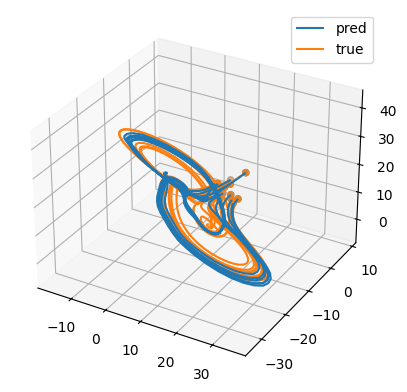

In [35]:
plot([trajectory, test], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)
# plot([y_pred], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [36]:
system.calc_error(trajectory, test)

19.825510070517854